In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import ipywidgets as widgets  # not used, for future
from IPython.display import display
import nglview as nv
from io import StringIO
import time
import pandas as pd

In [17]:
def pos2pdb(positions):
    pdb_str = "MODEL\n"
    for i, pos in enumerate(positions):
        pdb_str += f"ATOM  {i+1:5d}  CA  ALA A{i+1:4d}    {pos[0]:8.3f}{pos[1]:8.3f}{0.0:8.3f}  1.00  0.00           C  \n"
    pdb_str += "ENDMDL\n"
    return pdb_st

In [18]:

start_time = time.time()

id = 21072500

def student_id_to_initial_T(id):
 r = id % 10000000
 return (r / 10000000) * 6 + 1
T = student_id_to_initial_T(id)
N = 100  # Number of atoms
d = 2  # a 2D system
rho = 0.8  # The (reduced units) density (in 2D)

T0 = T  # Reduced temperature (in reduced units)
Ti = T0  # Initial Temperature (in reduced units)
# the Interatomic Potential (a special case of a Materials Relation)
epsilon = 1.0
sigma = 1.0
dt = 0.0025
max_steps = 1000
print(T0,T)

1.6435 1.6435


In [19]:
# From the equation for the density. 
L = np.sqrt(N / rho)  # length of the simulation box (supercell) side.

a = L / np.sqrt(N)  # Lattice parameter 

Lx, Ly = L, L  # Simulation box size in x and y

# Create the lattice positions
positions = []
for i in range(int(np.sqrt(N))):
    for j in range(int(np.sqrt(N))):
        x = i * a
        y = j * a
        positions.append([x, y])

positions = np.array(positions)

# Generate random velocities for the particles
velocities = np.random.randn(N, d)

m = 1
k_B =1

# Rescale velocities to match the desired initial temperature [see lecture notes]
v_s = np.sum(velocities**2, axis=1)
ke = 0.5 * np.sum(v_s)
ke_target = N * T0
scaling_factor = np.sqrt(ke_target / ke)
velocities *= scaling_factor


def calculate_temperature(velocities, m, k_B):

    v_squared = np.sum(velocities**2, axis=1)
    ke = 0.5 * np.sum(v_squared)  
    temperature = (2 * ke) / (d * N * k_B)
    return temperature


temperature = calculate_temperature(velocities, m, k_B)
print(f"Calculated Temperature: {temperature:}")


# 验证所有粒子的速度是否一致
v_squared = np.sum(velocities**2, axis=1)  # 计算每个粒子的速度平方和
print("vsquared:")
print(v_squared)
if np.allclose(v_squared, v_squared[0], rtol=1e-5):
    print("if all the vs same, successful")
else:
    print("if all the vs not the same，failed。")


Calculated Temperature: 1.6434999999999997
vsquared:
[ 3.26173344  5.81898907  5.13916632  5.0947651   1.58396245  5.36981891
  1.33513477  1.97913997  4.12990961  0.54202287  3.51614934  0.95389238
  0.47952203  2.21454072  1.34674078  1.74851641  0.78940582  0.14265453
  0.65307385  5.69190385  6.95220792  5.83070665  0.05495122  4.86294776
  5.75752049  0.38326302  2.9389038   3.43472155  4.18327982  5.20807365
  0.31993238  5.40266103  0.65441681  4.8503115   0.09685677  2.62622406
  0.847855    0.35392219 13.59493008  2.48352976  0.23701821 12.33746478
  3.68211413  2.54709828  3.27167574  0.89336409  0.22154414  2.6736767
  4.3988051   1.56145005  3.32086004  2.81542168  6.30066276  3.52148861
  3.57412349  0.20021472  9.16298892  5.83351769  2.61453331  3.42019986
  1.4957509   7.41715461  2.91687248  4.66278324  0.84667559  5.20652115
  0.69017556  4.23741909  2.68859291  6.91734024  9.63065108 11.5495769
  5.80653757  1.92928556  3.09001739  7.24203196 10.38113282  6.09694839


In [20]:
def compute_force(positions, epsilon, sigma):   
    
    # return an array (same shape as the positions numpy array) 
    # but all elements are zero
    forces = np.zeros_like(positions) 
    
    pot_energy = 0

    for i in range(N):        
        for j in range(i + 1, N):            
            rij = positions[i] - positions[j]                        
            rij = rij - np.round(rij / L) * L  # Periodic boundary conditions
            r=np.sqrt(rij.dot(rij))
            if r<0.2: # avoid blow out due to too close, or overlaping atoms
                r=0.2    
            # force2 is the magnitude of the force!    
            force2 = 48 * epsilon * np.power(sigma, 12) / np.power(r, 13)- 24 * epsilon * np.power(sigma, 6) / np.power(r, 7)  
            force=force2*rij/r                        
            forces[i] += force            
            forces[j] -= force    
          
            # the pot energy:
            pe = 4 * epsilon * (np.power(sigma/r, 12) - np.power(sigma/r, 6))
            if pe > 1000:  # in case atoms are overlapping...
                print('posible overlap - warning', i, j, r, rij, pe)
            pot_energy = pot_energy + pe

    return forces, pot_energy

In [21]:
def compute_kinetic_energy(velocities):
    kinetic_energy = 0.5 * np.sum(velocities**2)
    temperature = kinetic_energy / N  # Equipartition Theorem in 2D!
    return kinetic_energy, temperature

In [22]:
def update_positions(positions, velocities, forces, epsilon, sigma, dt):

    # First update positions based on current velocities and forces (Verlet step 1) or the  **first half-step of the Velocity Verlet method**
    positions += velocities * dt + 0.5 * forces * dt ** 2
    
    positions %= L  #  periodic boundary conditions
    
    # Calculate new forces after updating positions
    new_forces, pot_energy = compute_force(positions, epsilon, sigma)
    
    # Update velocities (Verlet step 2 or second half step)
    velocities += 0.5 * (forces + new_forces) * dt

    return positions, velocities, new_forces, pot_energy

In [23]:
# Initialize forces
forces, pot_energy = compute_force(positions, epsilon, sigma)

# Initialize an array to store positions for all steps
all_positions = np.zeros((max_steps, N, 2))

In [24]:
stats=[] # stores the thermodynamical statistical variables

with open("simulation_results_1000step.dat", "w") as f:
    f.write('#Step   Etot   PotE Ktot  T\n')
    
    for step in range(max_steps):
        positions, velocities, forces, pot_energy = update_positions(positions, velocities, forces, epsilon, sigma, dt)
        kinetic_energy, temperature = compute_kinetic_energy(velocities)
        tot_energy = pot_energy + kinetic_energy
        
        all_positions[step] = positions
                
        f.write(f"{step} {tot_energy/N:.6f} {pot_energy/N:.6f}  {kinetic_energy/N:.6f} {temperature:.2f}\n")
        stats.append([step, tot_energy/N, pot_energy/N, kinetic_energy/N, temperature])
        
stats = np.array(stats)

print("Stats shape:", stats.shape)


Stats shape: (1000, 5)


In [25]:
print(temperature)
# 结束计时
end_time = time.time()
execution_time = end_time - start_time
print(f"代码运行时间为: {execution_time:.4f} s")


1.1136450056189222
代码运行时间为: 90.5112 s


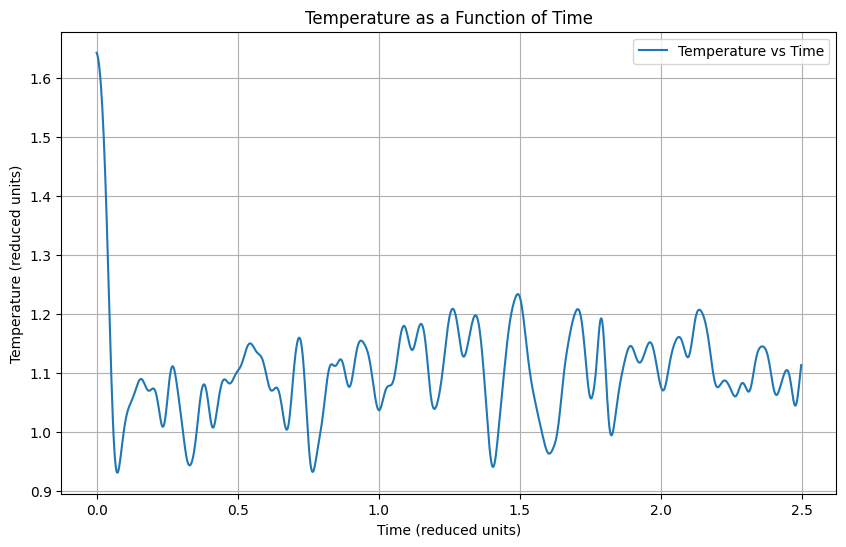

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(stats[:, 0] * dt, stats[:, 4], label='Temperature vs Time')  # stats[:, 0] 为时间步长，stats[:, 4] 为温度
plt.xlabel('Time (reduced units)')
plt.ylabel('Temperature (reduced units)')
plt.title('Temperature as a Function of Time')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
stats_df = pd.DataFrame(stats, columns=['Step', 'Total Energy', 'Potential Energy', 'Kinetic Energy', 'Temperature'])
# 计算温度的期望值
expectation_value_T = stats_df['Temperature'].mean()
print(f"温度的期望值为: {expectation_value_T:.4f}")

温度的期望值为: 1.1010


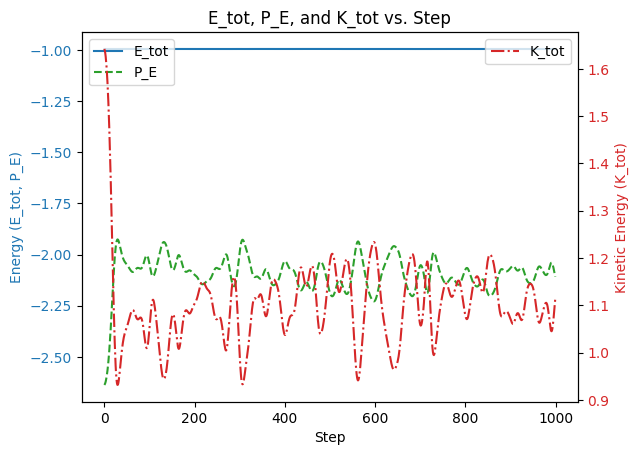

In [28]:
step = stats[:, 0]  
E_tot = stats[:, 1]  
P_E = stats[:, 2]  
K_tot = stats[:, 3]  
T     = stats[:,4]

fig, ax1 = plt.subplots()

ax1.set_xlabel('Step')
ax1.set_ylabel('Energy (E_tot, P_E)', color='tab:blue')
ax1.plot(step, E_tot, label='E_tot', color='tab:blue', linestyle='-')
ax1.plot(step, P_E, label='P_E', color='tab:green', linestyle='--')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc='upper left')

# Create a second y-axis (y2) sharing the same x-axis
ax2 = ax1.twinx()
ax2.set_ylabel('Kinetic Energy (K_tot)', color='tab:red')
ax2.plot(step, K_tot, label='K_tot', color='tab:red', linestyle='-.')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.legend(loc='upper right')

# Add a title and display the plot
plt.title('E_tot, P_E, and K_tot vs. Step')
plt.show()

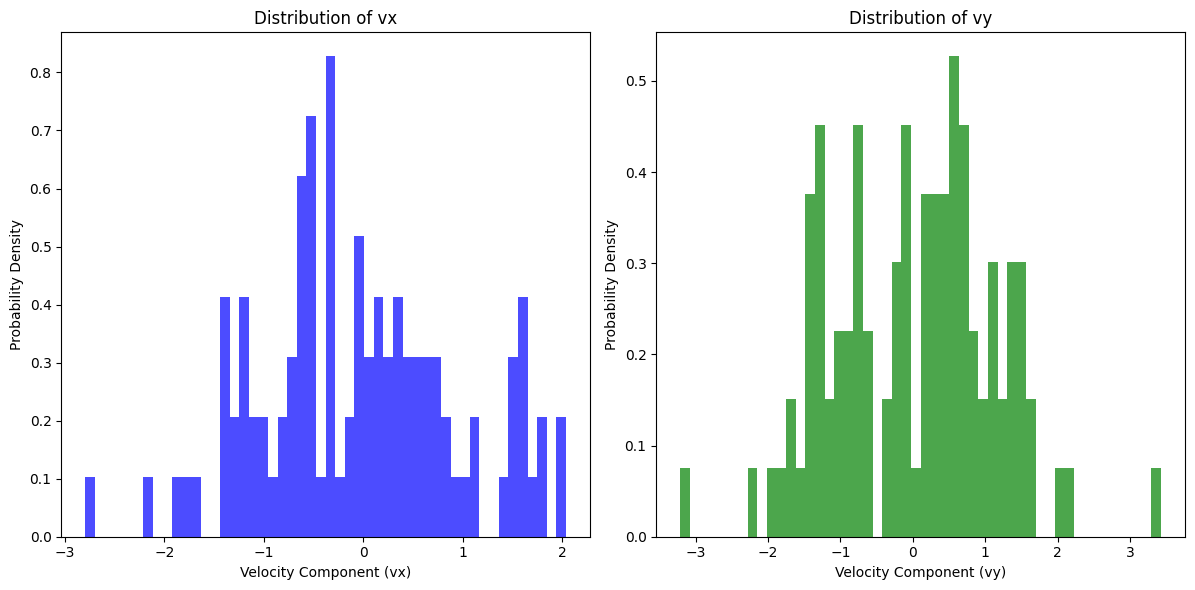

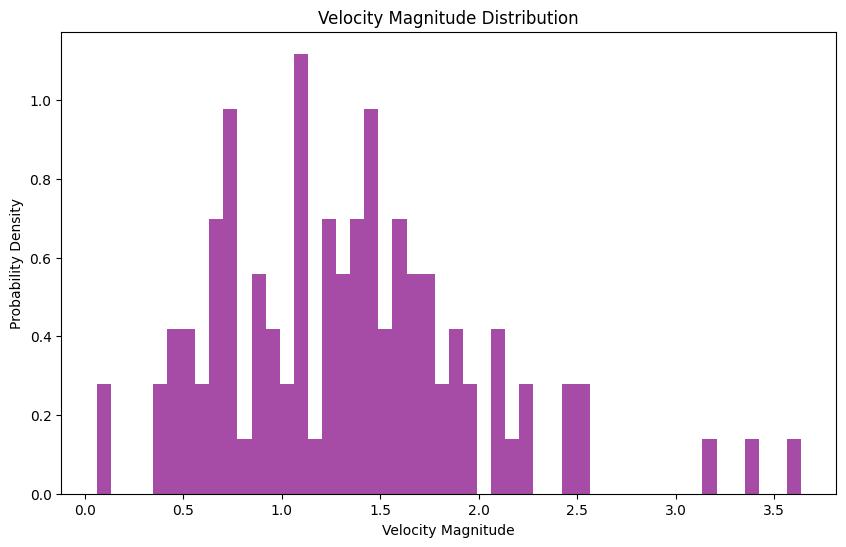

In [29]:
# Extract velocity components
vx = velocities[:, 0]  # x-component
vy = velocities[:, 1]  # y-component
if velocities.shape[1] == 3:
    vz = velocities[:, 2]  # z-component

# Calculate velocity magnitudes
velocity_magnitude = np.sqrt(np.sum(velocities**2, axis=1))

# Plot velocity components
plt.figure(figsize=(18, 6))

# x-component histogram
plt.subplot(1, 3, 1)
plt.hist(vx, bins=50, density=True, alpha=0.7, color='b')
plt.xlabel('Velocity Component (vx)')
plt.ylabel('Probability Density')
plt.title('Distribution of vx')

# y-component histogram
plt.subplot(1, 3, 2)
plt.hist(vy, bins=50, density=True, alpha=0.7, color='g')
plt.xlabel('Velocity Component (vy)')
plt.ylabel('Probability Density')
plt.title('Distribution of vy')

# z-component histogram (if 3D)
if velocities.shape[1] == 3:
    plt.subplot(1, 3, 3)
    plt.hist(vz, bins=50, density=True, alpha=0.7, color='r')
    plt.xlabel('Velocity Component (vz)')
    plt.ylabel('Probability Density')
    plt.title('Distribution of vz')

plt.tight_layout()
plt.show()

# Plot velocity magnitude distribution
plt.figure(figsize=(10, 6))
plt.hist(velocity_magnitude, bins=50, density=True, alpha=0.7, color='purple')
plt.xlabel('Velocity Magnitude')
plt.ylabel('Probability Density')
plt.title('Velocity Magnitude Distribution')
plt.show()

In [30]:
# Arrays to store positions for visualization
trajectories = np.zeros((max_steps, N, 3))  # Corrected to match the shape of positions (N, 3)
trajectories[0] = positions

# Molecular dynamics loop
for step in range(1, max_steps):
    # Update positions
    positions += velocities * dt
    
    # Apply periodic boundary conditions
    positions = apply_periodic_boundary(positions, L)
    
    # Store positions
    trajectories[step] = positions

# 3D Visualization with Animation
def update_graph(num, data, graph):
    graph._offsets3d = (data[num, :, 0], data[num, :, 1], data[num, :, 2])
    return graph

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Set axis labels and limits
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_zlabel('Z Position')
ax.set_title('Molecular Dynamics Simulation - Particle Trajectories (3D)')
ax.set_xlim(0, L)
ax.set_ylim(0, L)
ax.set_zlim(0, L)

# Initial scatter plot
graph = ax.scatter(trajectories[0, :, 0], trajectories[0, :, 1], trajectories[0, :, 2], s=20, c='b', alpha=0.6)

# Animation
ani = animation.FuncAnimation(fig, update_graph, frames=max_steps, fargs=(trajectories, graph), interval=10, blit=False)

plt.show()



ValueError: could not broadcast input array from shape (100,2) into shape (100,3)